# PixelCNN: A Generative Model
PixelCNN is a type of autoregressive generative model developed for modeling images. It captures the dependencies between pixels, allowing it to generate new images pixel by pixel. Unlike traditional generative models, PixelCNN models the conditional distribution of each pixel given the previous ones.


## Autoregressive Models
Autoregressive models aim to predict the next element in a sequence based on prior elements. In the context of images, PixelCNN models the probability distribution of each pixel given all previous pixels in raster order (top to bottom, left to right). This enables generating images from scratch.

The key idea of PixelCNN is to factor the image's joint distribution into a product of conditional distributions:
$$ P(x) = \prod_i P(x_i | x_{1:i-1}) $$

Where each pixel is conditioned on the previous pixels.


## PixelCNN Architecture
PixelCNN uses a stack of convolutional layers where each layer is masked to ensure that the pixel at position (i, j) only depends on previous pixels. The network models the conditional probability of a pixel given its neighbors.

The structure can be visualized as:

![PixelCNN Architecture](https://camo.githubusercontent.com/2f581257c289298057989d11aa1ad507c2af397b2471c592f7b17a5dbecd731e/687474703a2f2f736572676569747572756b696e2e636f6d2f6173736574732f323031372d30322d32322d3138333031305f343739783439345f7363726f742e706e67)  <!-- Add actual image reference here -->


## PixelCNN Architecture
PixelCNN uses a stack of convolutional layers where each layer is masked to ensure that the pixel at position (i, j) only depends on previous pixels. The network models the conditional probability of a pixel given its neighbors.

The structure can be visualized as:

![PixelCNN Architecture](https://camo.githubusercontent.com/2b432c6d87633c75685c3703167c0a6b5a6d6592a7ca95540bf02f6de890052c/68747470733a2f2f6c696c69616e77656e672e6769746875622e696f2f6c696c2d6c6f672f6173736574732f696d616765732f706978656c2d636e6e2e706e67)  <!-- Add actual image reference here -->


## Masked Convolutions
PixelCNN employs masked convolutions to ensure that future pixels are not used in the computation of the current pixel's distribution. There are two types of masks:

- **Mask A**
- **Mask B**

This technique helps preserve the autoregressive nature of the model.


## Implementation

PyTorch buffers are tensor attributes associated with a PyTorch module or model similar to parameters, but unlike parameters, buffers are not updated during training.



### Data Preparation

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # Binarize the dataset
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.53MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 242kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.12MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train Dataset Size: 60000
Test Dataset Size: 10000


### Define Masked Convolutions

In [ ]:
import torch.nn as nn

class MaskedConv2d(nn.Conv2d):
    """
    Implements masked convolution as used in PixelCNN.
    Mask A: Masks out all pixels including the current pixel (used for the first layer).
    Mask B: Masks out all future pixels but includes the current pixel (used in other layers).
    """
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding)

        self.register_buffer('mask', torch.ones(out_channels, in_channels, kernel_size, kernel_size))
        center = kernel_size // 2

        for i in range(kernel_size):
            for j in range(kernel_size):
                if i > center or (i == center and j > center):
                    self.mask[:, :, i, j] = 0 

        if mask_type == 'A':
            self.mask[:, :, center, center] = 0  

    def forward(self, x):
        self.weight.data *= self.mask 
        return super(MaskedConv2d, self).forward(x)

Mask A: Used in the first layer, masks the current pixel and all future pixels.

Mask B: Used in subsequent layers, masks only future pixels.

### Build PixelCNN Model

In [ ]:
class PixelCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64, kernel_size=7):
        super(PixelCNN, self).__init__()

        self.layers = nn.ModuleList()

        self.layers.append(MaskedConv2d('A', input_channels, hidden_channels, kernel_size, padding=kernel_size//2))

        for _ in range(6):
            self.layers.append(MaskedConv2d('B', hidden_channels, hidden_channels, kernel_size, padding=kernel_size//2))
            self.layers.append(nn.ReLU())

        self.layers.append(MaskedConv2d('B', hidden_channels, hidden_channels, kernel_size=1, padding=0))
        self.layers.append(nn.ReLU())
        self.layers.append(MaskedConv2d('B', hidden_channels, input_channels, kernel_size=1, padding=0))
        self.layers.append(nn.Sigmoid())  

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Train the Model

Epoch 1/10, Train Loss: 0.1243, Test Loss: 0.0864
Epoch 2/10, Train Loss: 0.0837, Test Loss: 0.0817
Epoch 3/10, Train Loss: 0.0814, Test Loss: 0.0796
Epoch 4/10, Train Loss: 0.0798, Test Loss: 0.0783
Epoch 5/10, Train Loss: 0.0788, Test Loss: 0.0778
Epoch 6/10, Train Loss: 0.0780, Test Loss: 0.0780
Epoch 7/10, Train Loss: 0.0772, Test Loss: 0.0768
Epoch 8/10, Train Loss: 0.0767, Test Loss: 0.0765
Epoch 9/10, Train Loss: 0.0762, Test Loss: 0.0762
Epoch 10/10, Train Loss: 0.0761, Test Loss: 0.0761


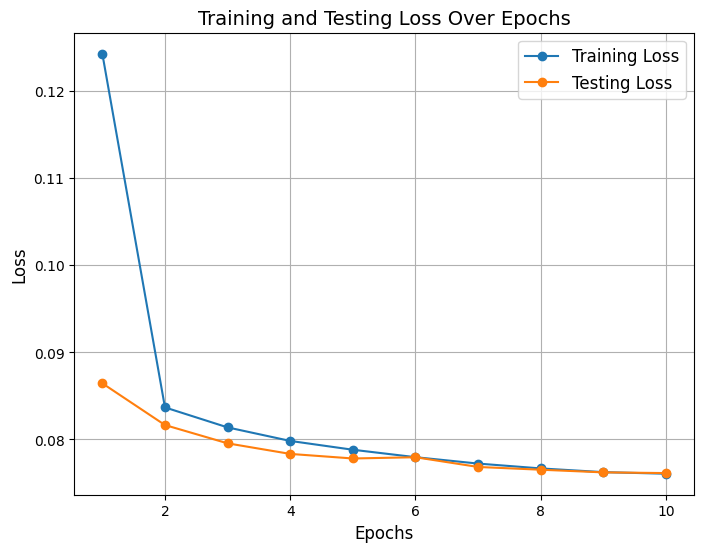

In [ ]:
from torch.optim import Adam
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = PixelCNN().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

def train_pixelcnn(model, train_loader, test_loader, epochs=10):
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            images, _ = batch
            images = images.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                images, _ = batch
                images = images.to(device)
                output = model(images)
                loss = criterion(output, images)
                test_loss += loss.item()

        test_losses.append(test_loss / len(test_loader))
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses

train_losses, test_losses = train_pixelcnn(model, train_loader, test_loader)

def plot_loss_curves(train_losses, test_losses):
    """
    Plot training and testing loss curves over epochs.
    """
    plt.figure(figsize=(8, 6))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, test_losses, label='Testing Loss', marker='o')

    plt.title('Training and Testing Loss Over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_loss_curves(train_losses, test_losses)

### Generate Samples

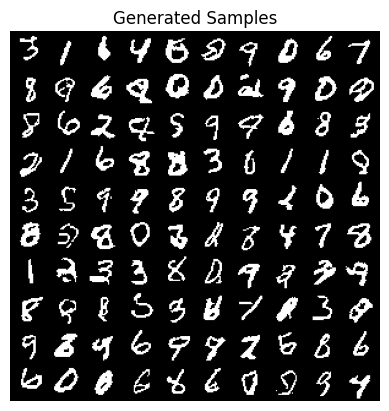

In [ ]:
def generate_samples(model, num_samples=100, img_size=(28, 28)):
    model.eval()
    samples = torch.zeros((num_samples, 1, *img_size)).to(device)
    with torch.no_grad():
        for i in range(img_size[0]):
            for j in range(img_size[1]):
                out = model(samples)
                samples[:, :, i, j] = (torch.bernoulli(out[:, :, i, j])).detach()
    return samples

samples = generate_samples(model)
grid = torchvision.utils.make_grid(samples.cpu(), nrow=10)
plt.imshow(grid.permute(1, 2, 0))
plt.title("Generated Samples")
plt.axis('off')
plt.show()